# DeepSeekMoE论文
MoE(Mixture of Experts, 混合专家模型)是一种稀疏架构，每次推理时只会使用对应的专家模型进行推理。Dense模型是指每次推理时会使用所有的参数进行推理。
## 过往认为MoE存在的问题
1. MoE的专家模型适用于特定领域，在通用领域表现会差
2. 由于训练和微调时涉及的稀疏激活机制，MoE 模型在微调时往往不如 dense 模型那样直接有效，需要更复杂的调参和策略
3. 传统 MoE Routed Expert 路由选择不平衡导致的两个问题：
   1. 路由选择崩溃（rote collapse）：模型总是选择少数的几个专家模型，导致其它专家无法得到充分训练，影响模型的整体性能和专家专业化的实现。
   2. 计算瓶颈加剧：当专家分布在多个设备上时，负载不平衡会加剧计算瓶颈，降低计算资源的利用效率。
## DeepSeek的解决方法
1. 使用 shared Expert对通用知识进行回答
2. Deepseek V3采用Auxiliary-Loss-Free Strategy for Load Balancing动态路由与自适应容量，解决MoE的负载均衡难题,更方面模型进行训练微调。但整体这类Sparse Model相比全连接层的Dense Model更不稳定, 需要考虑稀疏激活、Route Collapse路由崩溃、专家平衡和门控网络优化等问题，
## DeepSeekMoE论文核心内容
1. 细粒度专家分割（finely segmenting the experts into 𝑚𝑁 ones and activating 𝑚𝐾 from them），使用更小的专家模型，本质就是将专家模型参数减小，增加数量。
2. 针对通用知识。使用共享专家隔离（isolating 𝐾𝑠 experts as shared ones），选择 $k_s$ 个专家模型，共享专家专门用于捕捉和整合不同上下文的通用知识，每次都带共享专家

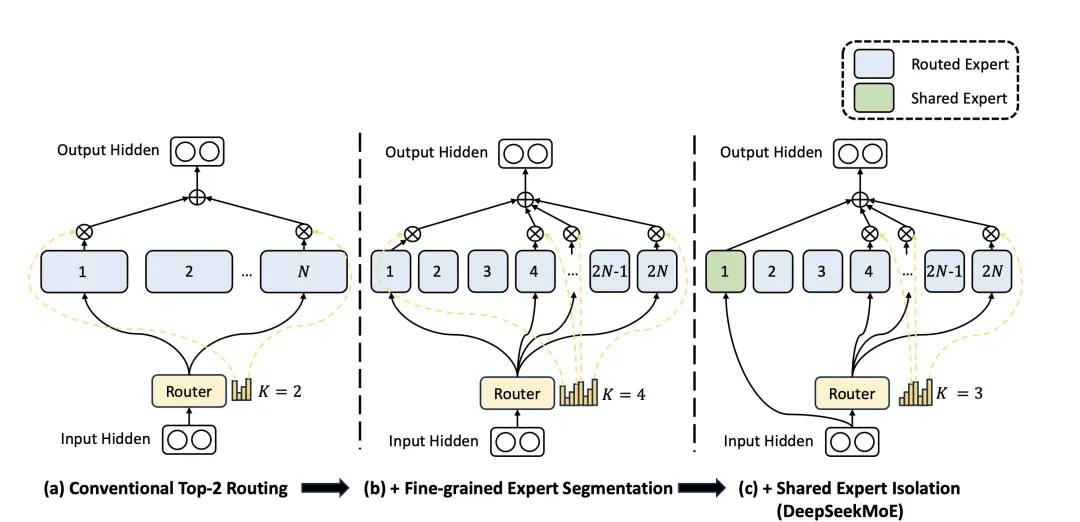

3. 针对传统MoE Routed Expert 路由选择不平衡的问题：
   1. expert - level balance loss（专家级别平衡损失）：控制对专家负载平衡的约束程度，尽量让每个专家都能得到足够的训练机会，避免路由崩溃route collapse;计算基于每个专家被选中的频率和每个专家的平均样本数,通过调整超参数（专家级别平衡因子），可以控制对专家负载平衡的约束程度
   2. device - level Balance Loss（设备平衡损失）：将所有路由专家划分为D个组，并将每个组部署在单个设备上。计算基于设备上所有专家的平均被选中频率和设备上所有专家处理的平均样本数的值。通过超参数（设备级别平衡因子）来控制设备间的负载平衡，以确保设备间的计算负载相对均衡，避免出现计算瓶颈。

# DeepSeek v2
主要有 DeepSeek MoE 和 MLA 组成，其中,MLA 主要是为了减少 kv 缓存

## MHA
MHA是最基本的多头注意力机制，假设输入的向量序列是 \(x_1,x_2,...,x_l\) ，其中\(x_i \in \mathbf{R}^d\),d是输入向量的维度。那么
$$o_t= \{o_t^1, o_t^2,...,o_t^h\}$$
$$o_t^s = Attention(q_t^s,k_{i \leq t}^s, v_{i \leq t}^s) = \sum_{i=1}^t \frac{\exp{q_t^s * k_i^{sT}} * v_i^s}{\sum_{i=1}^{t} \exp{q_t^s * k_i^{sT}}}$$
$$q_i^s = x_i * W_q^s \in \mathbf{R}^{d_k}  ,   W_q^s \in \mathbf{R}^{d \times d_k}$$
$$k_i^s = x_i * W_k^s \in \mathbf{R}^{d_k}  ,   W_k^s \in \mathbf{R}^{d \times d_k}$$
$$v_i^s = x_i * W_v^s \in \mathbf{R}^{d_v}  ,   W_v^s \in \mathbf{R}^{d \times d_v}$$
其中，$d$ 是输入维度，$h$ 是多头的个数，通常$d_k=d_v=d/h$,$l$ 表示层数。
那么参数量是$3 \times d \times d_k \times h \times l$，这里是将 $d_k = d_v$计算的。

## MQA
MQA是将每一层的K都设置为一个K，每一层的V都设置为一个V。这样减少参数量和kv缓存。假设输入的向量序列是 \(x_1,x_2,...,x_l\) ，其中\(x_i \in \mathbf{R}^d\),d是输入向量的维度。那么
$$o_t= \{o_t^1, o_t^2,...,o_t^h\}$$
$$o_t^s = Attention(q_t^s,k_{i \leq t}^s, v_{i \leq t}^s) = \sum_{i=1}^t \frac{\exp{q_t^s * k_i^{T}} * v_i}{\sum_{i=1}^{t} \exp{q_t^s * k_i^{T}}}$$
$$q_i^s = x_i * W_q^s \in \mathbf{R}^{d_k}  ,   W_q^s \in \mathbf{R}^{d \times d_k}$$
$$k_i = x_i * W_k \in \mathbf{R}^{d_k}  ,   W_k \in \mathbf{R}^{d \times d_k}$$
$$v_i = x_i * W_v \in \mathbf{R}^{d_v}  ,   W_v \in \mathbf{R}^{d \times d_v}$$
其中，$d$ 是输入维度，$h$ 是多头的个数，通常$d_k=d_v=d/h$,$l$ 表示层数。
那么参数量是$d \times d_k \times h \times l + 2 \times d \times d_k \times l$，这里是将 $d_k = d_v$计算的。参数量少了$h$倍。

## GQA
GQA是将每一层的头分为 $g$ 个组,其中h保证一定能够被 $g$ 整除。那么对应的公式可以改为：
$$o_t^s = Attention(q_t^s,k_{i \leq t}^s, v_{i \leq t}^s) = \sum_{i=1}^t \frac{\exp{q_t^s * k_i^{\color{red}{[sg/h]}T}} * v_i^s}{\sum_{i=1}^{t} \exp{q_t^s * k_i^{\color{red}{[sg/h]}T}}}$$
$[ \cdot]$ 是上取整符号
## 参考资料
[缓存与效果的极限拉扯：从MHA、MQA、GQA到MLA](https://spaces.ac.cn/archives/10091 "苏剑林")
[deepseek技术解读(1)-彻底理解MLA（Multi-Head Latent Attention）](https://zhuanlan.zhihu.com/p/16730036197 "姜富春​ 中国科学院大学 计算机技术硕士")